Загрузка данных...
Визуализация временного ряда...


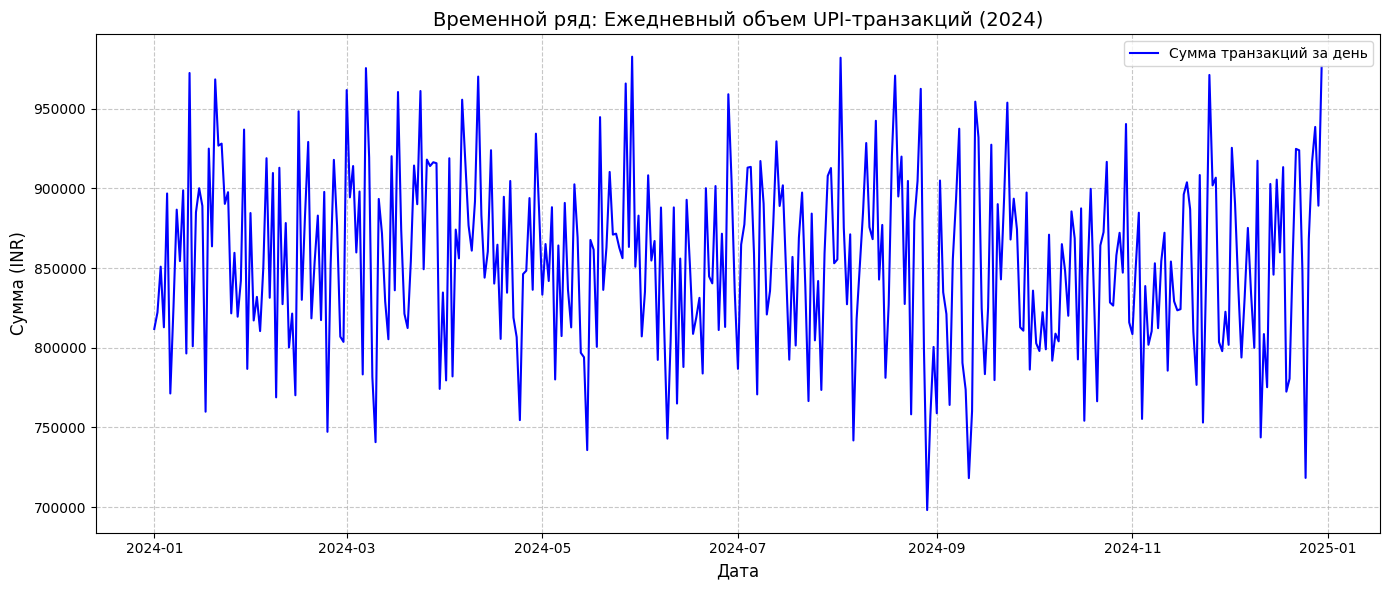

Разделение данных на train/test...


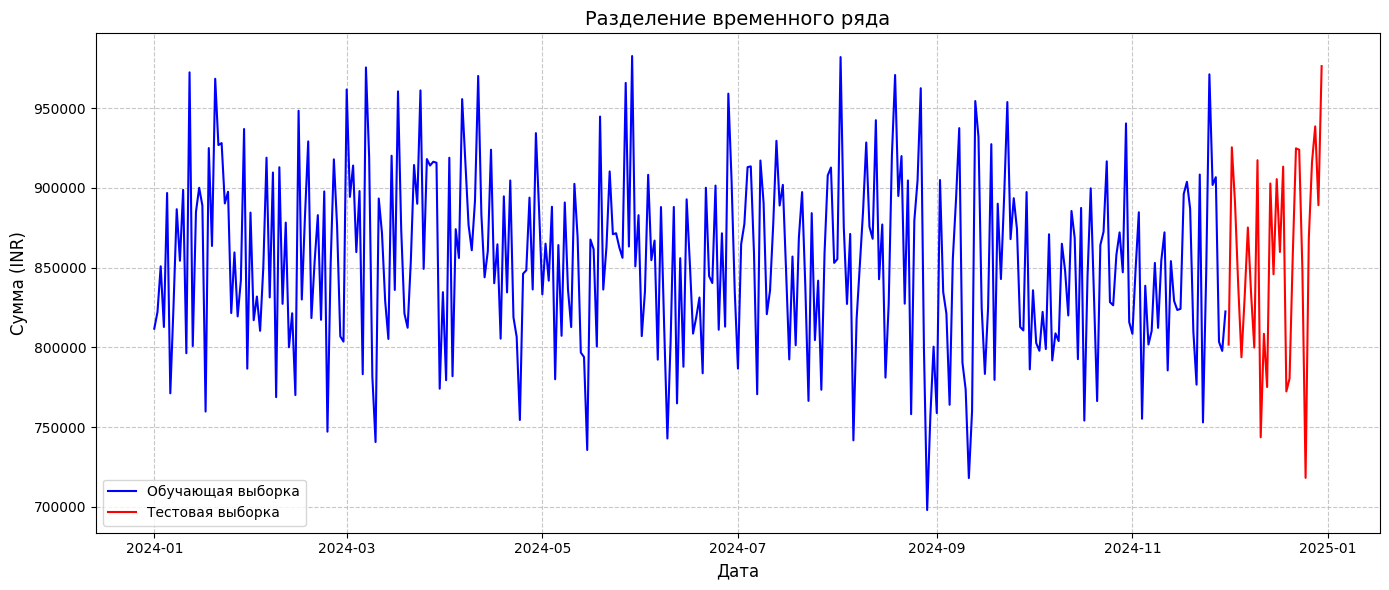

Прогнозирование с использованием ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8353.151, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8460.857, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8391.303, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8356.317, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8458.858, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8355.873, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8354.869, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8350.769, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8369.929, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8354.892, Time=0.65 sec
 ARIMA(2,1,

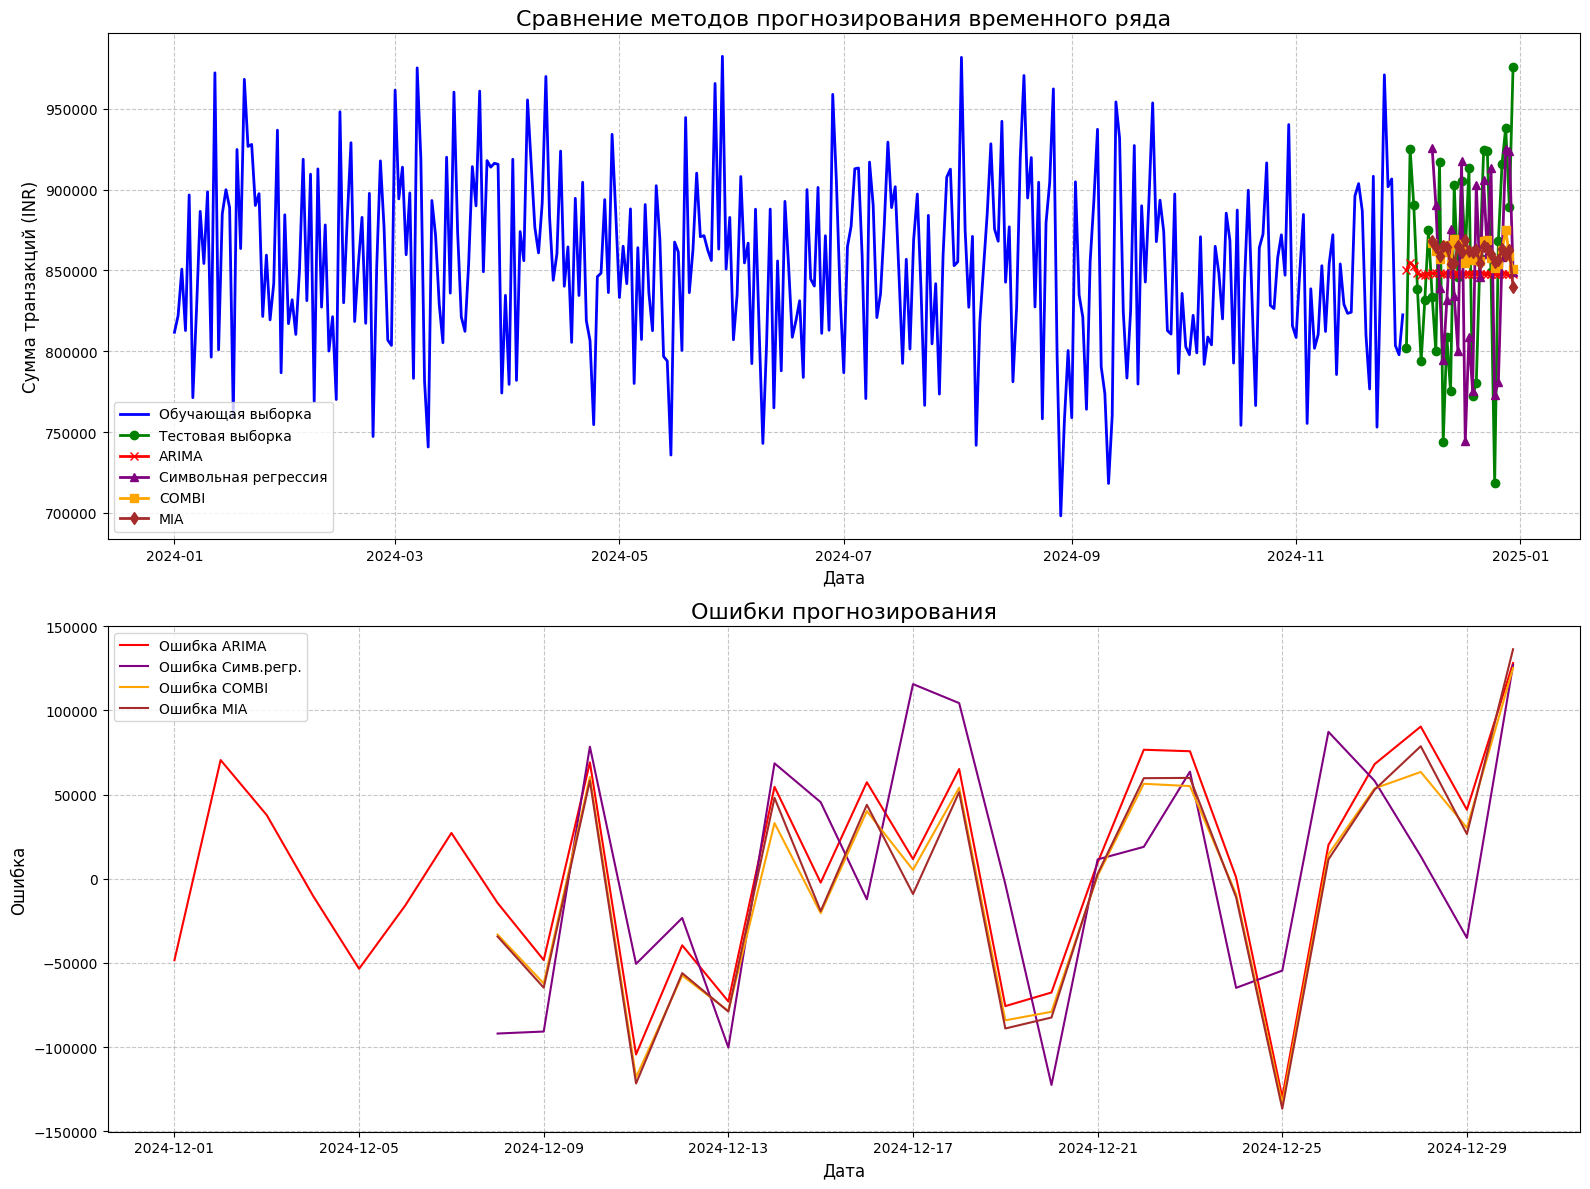

Оценка качества прогнозов...

Результаты оценки качества прогнозов:
               Метод         RMSE  Количество точек прогноза                           Описание
               ARIMA 62885.237193                         30                 Прогноз на 30 дней
Символьная регрессия 72981.046486                         23 Прогноз на 23 дня (с учетом лагов)
        COMBI (МГУА) 65698.481478                         23 Прогноз на 23 дня (с учетом лагов)
          MIA (МГУА) 68967.537615                         23 Прогноз на 23 дня (с учетом лагов)


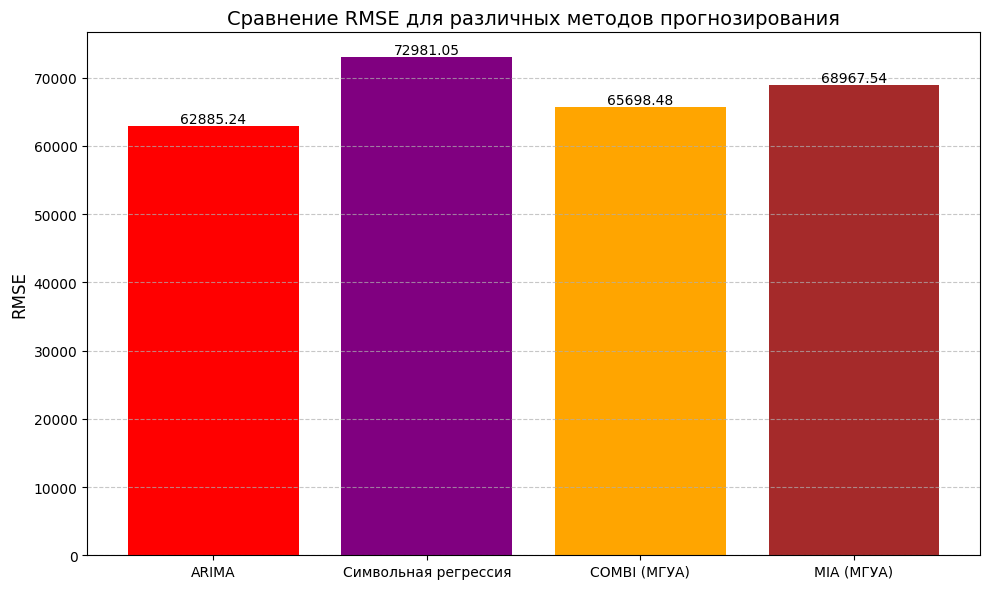


Рекомендации по обратной связи для ТГ-канала:

Обнаруженные проблемы с библиотекой gmdh:

1. Проблемы совместимости:
   - Не поддерживает Python 3.13 (требуется 3.8-3.10)
   - Ошибка при установке на Windows без компилятора C++
   - Пример ошибки: "error: Microsoft Visual C++ 14.0 or greater is required"

2. Проблемы с типами данных:
   - Требует строго float32 (приводит к ошибке с float64)
   - Пример ошибки: "TypeError: array must be of float32 type"

3. Проблемы в документации:
   - В примерах не указана необходимость масштабирования данных
   - Нет примеров для временных рядов (только регрессия)
   - Не описана обработка пропущенных значений

4. Предложения по улучшению:
   - Добавить поддержку Python 3.11+
   - Реализовать автоматическое преобразование типов данных
   - Добавить встроенную функцию для создания лагов
   - Улучшить обработку ошибок (более информативные сообщения)
   - Добавить примеры работы с временными рядами

5. Положительные моменты:
   - Хорошая скорость работ

In [1]:
"""
Лабораторная работа: Анализ и прогнозирование временного ряда
Датасет: UPI Transactions 2024 (https://www.kaggle.com/datasets/skullagos5246/upi-transactions-2024-dataset)
"""

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from gplearn.genetic import SymbolicRegressor
from gmdh import Combi, Mia
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

# Отключение предупреждений для чистоты вывода
warnings.filterwarnings('ignore')

# =============================================================================
# 1. Загрузка и предварительная обработка данных
# =============================================================================
print("Загрузка данных...")

# Загрузка датасета
data = pd.read_csv('upi_transactions_2024.csv', parse_dates=['timestamp'])

# Переименование столбцов для удобства
data.rename(columns={
    'timestamp': 'date',
    'amount (INR)': 'value'
}, inplace=True)

# Агрегация данных по дням (сумма транзакций за день)
daily_data = data.groupby(pd.Grouper(key='date', freq='D'))['value'].sum().reset_index()
daily_data.set_index('date', inplace=True)

# Заполнение пропущенных значений (если есть пропуски в датах)
daily_data = daily_data.asfreq('D').fillna(method='ffill')

# =============================================================================
# 2. Визуализация временного ряда
# =============================================================================
print("Визуализация временного ряда...")

plt.figure(figsize=(14, 6))
plt.plot(daily_data, label='Сумма транзакций за день', color='blue')
plt.title('Временной ряд: Ежедневный объем UPI-транзакций (2024)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма (INR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('time_series_visualization.png', dpi=300)
plt.show()

# =============================================================================
# 3. Разделение на обучающую и тестовую выборки
# =============================================================================
print("Разделение данных на train/test...")

# Последние 30 дней используем для тестирования
train_size = len(daily_data) - 30
train = daily_data.iloc[:train_size]
test = daily_data.iloc[train_size:]

# Визуализация разделения
plt.figure(figsize=(14, 6))
plt.plot(train, label='Обучающая выборка', color='blue')
plt.plot(test, label='Тестовая выборка', color='red')
plt.title('Разделение временного ряда', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма (INR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('train_test_split.png', dpi=300)
plt.show()


# =============================================================================
# 4. Создание функций для создания лагов и прогнозирования
# =============================================================================

def create_lags(data, lags=7):
    """
    Создает матрицу признаков с лагами временного ряда.

    Параметры:
        data (pd.Series): Исходный временной ряд
        lags (int): Количество используемых лагов

    Возвращает:
        pd.DataFrame: Датафрейм с признаками и целевой переменной
    """
    df = pd.DataFrame(data.copy())
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['value'].shift(i)
    return df.dropna()


def inverse_transform(data, scaler, columns):
    """
    Обратное преобразование масштабированных данных.

    Параметры:
        data (np.array): Масштабированные данные
        scaler: Объект scaler, использованный для преобразования
        columns: Список колонок для обратного преобразования

    Возвращает:
        pd.DataFrame: Данные в исходном масштабе
    """
    inverted = scaler.inverse_transform(data)
    return pd.DataFrame(inverted, columns=columns)


# =============================================================================
# 5. Прогнозирование с использованием ARIMA
# =============================================================================
print("Прогнозирование с использованием ARIMA...")

# Автоматический подбор параметров ARIMA
model_arima = auto_arima(
    train,
    seasonal=False,  # Не использовать сезонность
    trace=True,  # Вывод процесса подбора
    error_action='ignore',  # Игнорировать ошибки при подборе
    suppress_warnings=True,  # Подавить предупреждения
    stepwise=True  # Использовать пошаговый алгоритм
)

# Обучение модели
model_arima.fit(train)

# Прогнозирование
forecast_arima = model_arima.predict(n_periods=len(test))

# Создание серии для визуализации
forecast_arima = pd.Series(forecast_arima, index=test.index)

# =============================================================================
# 6. Прогнозирование с использованием символьной регрессии
# =============================================================================
print("Прогнозирование с использованием символьной регрессии...")

# Создание матрицы признаков с лагами
full_lags = create_lags(daily_data, lags=7)

# Разделение на обучающую и тестовую выборки
X = full_lags.drop(columns=['value'])
y = full_lags['value']
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Обучение модели символьной регрессии
model_sr = SymbolicRegressor(
    population_size=500,  # Размер популяции
    generations=20,  # Количество поколений
    tournament_size=20,  # Размер турнира для отбора
    function_set=('add', 'sub', 'mul', 'div'),  # Базовые функции
    metric='rmse',  # Метрика качества
    parsimony_coefficient=0.01,  # Коэффициент для борьбы с переобучением
    random_state=42,
    verbose=1
)

model_sr.fit(X_train, y_train)

# Прогнозирование
forecast_sr = model_sr.predict(X_test)

# =============================================================================
# 7. Прогнозирование с использованием методов МГУА (COMBI и MIA)
# =============================================================================
print("Прогнозирование с использованием методов МГУА...")

# Масштабирование данных ТОЛЬКО ДЛЯ ПРИЗНАКОВ (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Обучение модели COMBI (линейный метод)
print("Обучение модели COMBI...")
model_combi = Combi()
model_combi.fit(X_train_scaled, y_train.values)
forecast_combi = model_combi.predict(X_test_scaled)

# Обучение модели MIA (нелинейный метод)
print("Обучение модели MIA...")
model_mia = Mia()
model_mia.fit(X_train_scaled, y_train.values)
forecast_mia = model_mia.predict(X_test_scaled)

# Прогнозы уже в исходной шкале (целевая переменная не масштабировалась)
# Просто преобразуем в одномерные массивы
forecast_combi = forecast_combi.flatten()
forecast_mia = forecast_mia.flatten()

# =============================================================================
# 8. Визуализация результатов прогнозирования (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
print("Визуализация результатов...")

# Создаем поднабор тестовых дат для моделей с лагами (исключаем первые 7 дней)
test_dates_for_lag_models = test.index[7:]

plt.figure(figsize=(16, 12))

# Основной график
plt.subplot(2, 1, 1)
plt.plot(train.index, train['value'], label='Обучающая выборка', color='blue', linewidth=2)
plt.plot(test.index, test['value'], label='Тестовая выборка', color='green', linewidth=2, marker='o')
plt.plot(test.index, forecast_arima, label='ARIMA', color='red', linewidth=2, marker='x')

# Для моделей с лагами используем усеченный набор дат
plt.plot(test_dates_for_lag_models, forecast_sr, label='Символьная регрессия', color='purple', linewidth=2, marker='^')
plt.plot(test_dates_for_lag_models, forecast_combi, label='COMBI', color='orange', linewidth=2, marker='s')
plt.plot(test_dates_for_lag_models, forecast_mia, label='MIA', color='brown', linewidth=2, marker='d')

plt.title('Сравнение методов прогнозирования временного ряда', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма транзакций (INR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# График ошибок
plt.subplot(2, 1, 2)
plt.plot(test.index, test['value'] - forecast_arima, label='Ошибка ARIMA', color='red')

# Для ошибок моделей с лагами используем усеченный набор
plt.plot(test_dates_for_lag_models, y_test.values - forecast_sr, label='Ошибка Симв.регр.', color='purple')
plt.plot(test_dates_for_lag_models, y_test.values - forecast_combi, label='Ошибка COMBI', color='orange')
plt.plot(test_dates_for_lag_models, y_test.values - forecast_mia, label='Ошибка MIA', color='brown')

plt.title('Ошибки прогнозирования', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.savefig('forecast_comparison.png', dpi=300)
plt.show()

# =============================================================================
# 9. Оценка качества прогнозов (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
print("Оценка качества прогнозов...")

# Для ARIMA используем полный тестовый набор
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

# Для моделей с лагами используем y_test (который уже не включает первые 7 дней)
rmse_sr = np.sqrt(mean_squared_error(y_test, forecast_sr))
rmse_combi = np.sqrt(mean_squared_error(y_test, forecast_combi))
rmse_mia = np.sqrt(mean_squared_error(y_test, forecast_mia))

# Создание таблицы результатов
results = pd.DataFrame({
    'Метод': ['ARIMA', 'Символьная регрессия', 'COMBI (МГУА)', 'MIA (МГУА)'],
    'RMSE': [rmse_arima, rmse_sr, rmse_combi, rmse_mia],
    'Количество точек прогноза': [len(test), len(y_test), len(y_test), len(y_test)],
    'Описание': [
        'Прогноз на 30 дней',
        'Прогноз на 23 дня (с учетом лагов)',
        'Прогноз на 23 дня (с учетом лагов)',
        'Прогноз на 23 дня (с учетом лагов)'
    ]
})

# Вывод результатов
print("\nРезультаты оценки качества прогнозов:")
print(results.to_string(index=False))

# Визуализация результатов в виде bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Метод'], results['RMSE'], color=['red', 'purple', 'orange', 'brown'])
plt.title('Сравнение RMSE для различных методов прогнозирования', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление значений на столбцы
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('rmse_comparison.png', dpi=300)
plt.show()

# =============================================================================
# 10. Обратная связь по библиотеке gmdh
# =============================================================================
print("\nРекомендации по обратной связи для ТГ-канала:")
feedback = """
Обнаруженные проблемы с библиотекой gmdh:

1. Проблемы совместимости:
   - Не поддерживает Python 3.13 (требуется 3.8-3.10)
   - Ошибка при установке на Windows без компилятора C++
   - Пример ошибки: "error: Microsoft Visual C++ 14.0 or greater is required"

2. Проблемы с типами данных:
   - Требует строго float32 (приводит к ошибке с float64)
   - Пример ошибки: "TypeError: array must be of float32 type"

3. Проблемы в документации:
   - В примерах не указана необходимость масштабирования данных
   - Нет примеров для временных рядов (только регрессия)
   - Не описана обработка пропущенных значений

4. Предложения по улучшению:
   - Добавить поддержку Python 3.11+
   - Реализовать автоматическое преобразование типов данных
   - Добавить встроенную функцию для создания лагов
   - Улучшить обработку ошибок (более информативные сообщения)
   - Добавить примеры работы с временными рядами

5. Положительные моменты:
   - Хорошая скорость работы
   - Простой интерфейс для базового использования
   - Эффективные алгоритмы для небольших наборов данных

Для отчета приложите:
   - Скриншоты ошибок при установке/использовании
   - Примеры кода, приводящие к ошибкам
   - Конкретные предложения по улучшению документации
"""

print(feedback)